Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


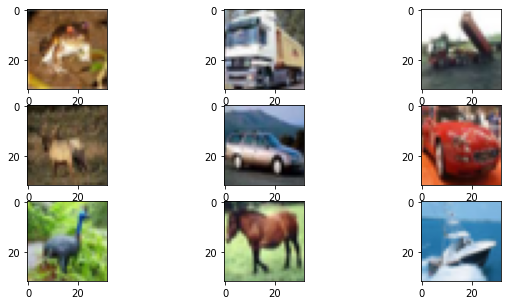

In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist, mnist,cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [3]:
pd.DataFrame(pd.value_counts(trainy.squeeze())).reset_index()

,index,0
0,9,5000
1,8,5000
2,7,5000
3,6,5000
4,5,5000
5,4,5000
6,3,5000
7,2,5000
8,1,5000
9,0,5000


In [4]:
pd.DataFrame(pd.value_counts(testy.squeeze())).reset_index()

,index,0
0,7,1000
1,6,1000
2,5,1000
3,4,1000
4,3,1000
5,2,1000
6,9,1000
7,1,1000
8,8,1000
9,0,1000


In [5]:
np.random.seed(1)
full_data = []
full_data_y = []
full_data_test = []
full_data_test_y = []

for j in list(set(trainy.squeeze().tolist())):
    if j not in [1,7]:
        temp_data = trainX[trainy.squeeze()==j]
        temp_y = trainy.squeeze()[trainy.squeeze()==j]
        print(j, sum(sum(sum(sum(np.isnan(temp_data))))), sum(np.isnan(temp_y)),temp_data.dtype, temp_y.dtype, temp_data.flatten().mean(),temp_data.flatten().std())
        
        index = np.random.choice(temp_data.shape[0], 1000, replace=False)
        left_index = [k for k in range(temp_data.shape[0]) if k not in index]
        full_data_test.append(temp_data[left_index[0:100],])
        full_data.append(temp_data[index,])

        full_data_y.extend(temp_y[index,])
        full_data_test_y.extend(temp_y[left_index[0:100],])
    else:
        temp_data = trainX[trainy.squeeze()==j,]
        temp_y = trainy.squeeze()[trainy.squeeze()==j]
        index = np.random.choice(temp_data.shape[0], 100, replace=False)
        full_data_test.append(temp_data[index,])
        full_data_test_y.extend(temp_y[index,])

0 0 0 uint8 uint8 142.365784765625 64.73853909545355
2 0 0 uint8 uint8 119.405596484375 59.35503796854208
3 0 0 uint8 uint8 116.23182356770833 65.73623445409126
4 0 0 uint8 uint8 111.77529895833334 55.12504739169542
5 0 0 uint8 uint8 117.39423971354167 63.76767742895832
6 0 0 uint8 uint8 106.5619337890625 58.36560191690341
8 0 0 uint8 uint8 133.47602604166667 63.42240462014516
9 0 0 uint8 uint8 124.27721360677083 69.59517222165293


In [6]:
full_data = np.array(full_data)
full_data_test = np.array(full_data_test)
full_data_y = np.array(full_data_y)
full_data_test_y = np.array(full_data_test_y)

In [7]:
for k in full_data_test:
    print(k.shape)

(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)
(100, 32, 32, 3)


In [8]:

label_desc={0:"airplane",1:"automobile",2:"bird",3:"cat",
4:"deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [9]:
# concatenating all the training data together
train_data_x = full_data[0]
train_data_y = full_data_y[0]
for j in range(1,full_data.shape[0]):
    train_data_x = np.vstack((train_data_x, full_data[j]))
    #train_data_y = np.hstack((train_data_y, full_data_y[j]))

# concatenating test data together
test_data_x = full_data_test[0]
test_data_y = full_data_test_y[0]
for j in range(1,full_data_test.shape[0]):
    test_data_x = np.vstack((test_data_x, full_data_test[j]))
    #test_data_y = np.hstack((test_data_y, full_data_test_y[j]))

In [10]:
test_data_y = full_data_test_y
train_data_y = full_data_y

In [11]:
# printing the shape of both datasets
print(train_data_x.shape, test_data_x.shape)

(8000, 32, 32, 3) (1000, 32, 32, 3)


In [12]:
# normalizing the data to 0-1
train_data_x = train_data_x.astype('float32') / 255.
test_data_x = test_data_x.astype('float32') / 255.
train_data_x = np.reshape(train_data_x, (len(train_data_x), 32, 32, 3))
test_data_x = np.reshape(test_data_x, (len(test_data_x), 32, 32, 3))

In [13]:
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [32]:
# creating the input layer
Input_layer = tf.keras.Input(shape=(32, 32, 3), name='input_layer')

# Encoder Layers
Encoder = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', name='ConvLayer1')(Input_layer)
#Encoder = tf.keras.layers.BatchNormalization(name='BatchNorm1')(Encoder)
Encoder = tf.keras.layers.LeakyReLU(name='LeakyRelu1')(Encoder)

Encoder = tf.keras.layers.Conv2D(32, kernel_size=3, strides=2, padding='same', name='ConvLayer2')(Encoder)
#Encoder = tf.keras.layers.BatchNormalization(name='BatchNorm2')(Encoder)
Encoder = tf.keras.layers.LeakyReLU(name='LeakyRelu2')(Encoder)



# Decoder Layers


Decoder = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides= 2, padding='same',name='ConvLayertranspose2')(Encoder)
#Decoder = tf.keras.layers.BatchNormalization(name='BatchNorm5')(Decoder)
Decoder = tf.keras.layers.LeakyReLU(name='LeakyRelu5')(Decoder)

Decoder = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding='same', name='ConvLayertranspose3')(Decoder)
#Decoder = tf.keras.layers.BatchNormalization(name='BatchNorm6')(Decoder)
Decoder = tf.keras.layers.LeakyReLU(name='LeakyRelu6')(Decoder)

# output
Output_layer = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=1,padding='same', activation='sigmoid', name='ConvLayertranspose4')(Decoder)

In [33]:
# declaring the autoencoder model
autoencoder = tf.keras.Model(Input_layer, Output_layer)
# declaring Adam optimizer with learning rate 0.0005
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
# compiling the model with mean squared error loss
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

In [34]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
ConvLayer1 (Conv2D)          (None, 32, 32, 64)        1792      
_________________________________________________________________
LeakyRelu1 (LeakyReLU)       (None, 32, 32, 64)        0         
_________________________________________________________________
ConvLayer2 (Conv2D)          (None, 16, 16, 32)        18464     
_________________________________________________________________
LeakyRelu2 (LeakyReLU)       (None, 16, 16, 32)        0         
_________________________________________________________________
ConvLayertranspose2 (Conv2DT (None, 32, 32, 32)        9248      
_________________________________________________________________
LeakyRelu5 (LeakyReLU)       (None, 32, 32, 32)        0   

In [35]:
# running the model with 10 epochs, 128 batch size 
hist = autoencoder.fit(train_data_x, train_data_x,
                epochs=10,
                batch_size=128,
                shuffle=True
                )

Epoch 1/10
63/63 [==============================] - 73s 1s/step - loss: 0.6588
Epoch 2/10
63/63 [==============================] - 66s 1s/step - loss: 0.1361
Epoch 3/10
63/63 [==============================] - 63s 998ms/step - loss: 0.0551
Epoch 4/10
63/63 [==============================] - 62s 980ms/step - loss: 0.0448
Epoch 5/10
63/63 [==============================] - 63s 992ms/step - loss: 0.0370
Epoch 6/10
63/63 [==============================] - 64s 1s/step - loss: 0.0311
Epoch 7/10
63/63 [==============================] - 65s 1s/step - loss: 0.0250
Epoch 8/10
63/63 [==============================] - 65s 1s/step - loss: 0.0224
Epoch 9/10
63/63 [==============================] - 63s 1s/step - loss: 0.0196
Epoch 10/10
63/63 [==============================] - 64s 1s/step - loss: 0.0185


In [36]:
# making predictions on the test data
decoded_images = autoencoder.predict(test_data_x)

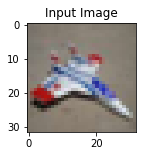

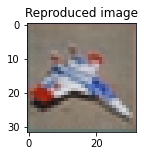

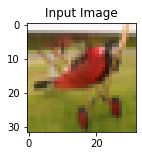

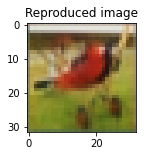

In [37]:
# plotting the reconstructed images 
plt.rcParams['figure.figsize']=(2,2)
for i in range(1,3):
    # Input image
    plt.imshow(test_data_x[i],cmap=pyplot.get_cmap('gray'))
    plt.title("Input Image")
    plt.gray()
    plt.show()
    # The reproduced image
    plt.imshow(decoded_images[i],cmap=pyplot.get_cmap('gray'))
    plt.title("Reproduced image")
    plt.gray()
    plt.show()
    
    

In [50]:
arg_1 = np.argmax(test_data_y==1)
arg_7 = np.argmax(test_data_y==7)

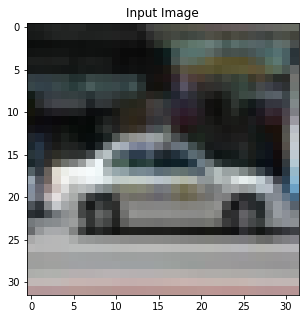

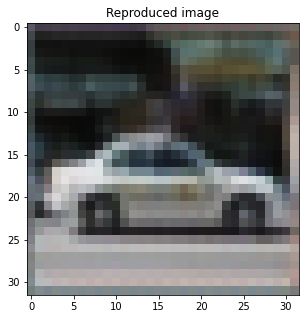

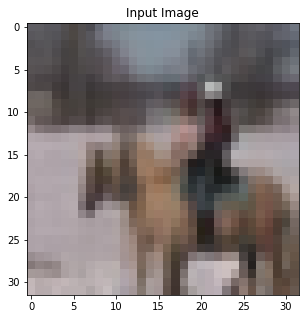

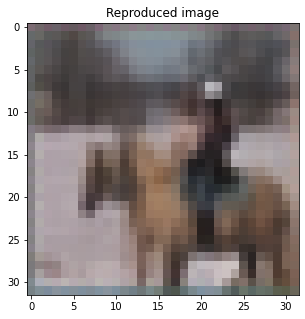

In [51]:
# plotting data on which the model was not trained
for j in [arg_1,arg_7]:
    # Input image
    plt.imshow(test_data_x[j])
    plt.title("Input Image")
    plt.gray()
    plt.show()
    # The reproduced image
    plt.imshow(decoded_images[j])
    plt.title("Reproduced image")
    plt.gray()
    plt.show()

In [40]:
# getting the mean squared errors
ssi_vals = [SSIMLoss(test_data_x[j],decoded_images[j]).numpy() for j in range(len(decoded_images))]

In [41]:
ssi_vals = np.array(ssi_vals)

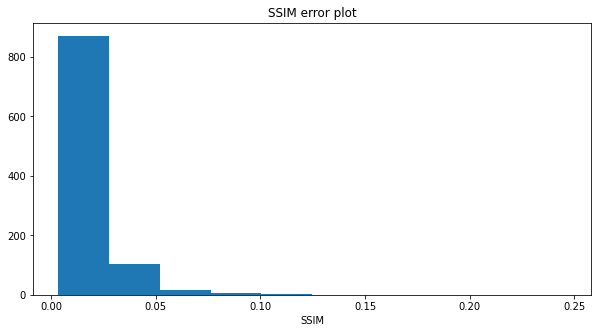

In [42]:
plt.rcParams['figure.figsize']=10,5
plt.hist(ssi_vals)
plt.title("SSIM error plot")
plt.xlabel("SSIM")
plt.show()

In [49]:
# keeping the threshold at 0.07
outcome = pd.DataFrame(np.unique(test_data_y[ssi_vals>0.035],return_counts=True)).T
outcome.columns = ['labels','count']
for j in range(outcome.shape[0]):
    outcome.loc[j,'labels'] = label_desc[outcome.loc[j,'labels']]
outcome

,labels,count
0,airplane,8
1,automobile,16
2,bird,8
3,cat,3
4,deer,12
5,dog,1
6,frog,8
7,horse,2
8,ship,8
9,truck,13
